# Titanic Exploratory Data Analysis
### Prediction of survival rate using 9 variables

For this analysis we use the <b>Titanic Kaggle Competition</b> dataset found on the Kaggle Data
Repository at the following location:

<a href=https://www.kaggle.com/c/titanic/data>Titanic Kaggle Competition Dataset</a>

The objective of the analysis is to classify passengers on the Titanic during the disaster
of 1912 according to survival

We aim to achieve this by following the ML pipeline approach of deploying a variety of ML
techniques to build a final predictive model with the highest possible accuracy. This
particular analysis comprises 4 notebooks as follows:

 1. <i>titanic_baseline</i> - Baseline predictive models (quick and dirty) to
 compare later results against
 2. <i>titanic_eda</i> - <b>This notebook</b>, Exploratory Descriptive Analysis (EDA)
 3. <i>titanic_features</i> - Perform feature engineering
 4. <i>titanic_final_model</i> - Final model

We hope to gain valuable insights by following this process. The various steps in the
process can be elaborated on as follows (the various notebooks will focus on different parts
 of the process as indicated):

- Load data (<i>all notebooks</i>)
- Prepare data
    - Clean data (<i>notebook 2</i>)
        - Missing values
        - Outliers
        - Erroneous values
    - Explore data (<i>notebook 2</i>)
        - Exploratory descriptive analysis (EDA)
        - Correlation analysis
        - Variable cluster analysis
    - Transform Data (<i>notebook 3</i>)
        - Engineer features
        - Encode data
        - Scale & normalise data
        - Impute data (if not done in previous steps)
        - Feature selection/ importance analysis
- Build model (<i>notebooks 1 & 4</i>)
    - Model selection
    - Data sampling (validation strategy, imbalanced classification)
    - Hyperparameter optimisation
- Validate model (<i>notebooks 1 & 4</i>)
    - Accuracy testing
- Analysis of results (<i>notebook 1 & 4</i>)
    - Response curves
    - Accuracy analysis
    - Commentary

The data dictionary for this dataset is as follows:

| Variable | Definition | Key |
|----------|------------|-----|
| survival | Survival	| 0 = No, 1 = Yes |
| pclass   | Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd |
|sex | Sex | male, female |
|Age | Age in years | Continuous |
|sibsp | # of siblings / spouses aboard the Titanic | 0, 1, 2, ..|
|parch | # of parents / children aboard the Titanic | 0, 1, 2 ..|
|ticket | Ticket number | PC 17599, STON/O2. 3101282, 330877 |
|fare | Passenger fare | Continuous |
|cabin | Cabin number | C123, C85, E46 |
|embarked | Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton |

Let us start the analysis for <b>notebook 2</b>!

This notebook follows on the previous notebook. We previously concluded that there is a very
 strong signal in the data, even without any pre-processing. We also found that
 several variables have potential for improving the model if pre-processed. The analysis
 also suggests that improvement could be gained by feature engineering. In this notebook we
 will gain an understanding of the data and consider ways of improving our existing score by
  re-doing our missing data imputation and performing feature engineering.

We will also learn more about the domain i.e. the events surrounding the accident.

We will perform an analysis on the entire training dataset i.e. 891 records. We will sense
check our findings against the test set to ensure the two are aligned. We will then make
some high level improvements to our models based on our findings and see if our accuracy
improves.

We start by discussing the data with domain experts, to build up an intuition about the data
. In my case I consulted the most knowledgeable person in our household regarding the matter
 i.e. my daughter whom has watched the movie several times. On asking her the question as to
  who the most likely people to survive the Titanic accident she came up with the following
  (without any hesitation or thought):

- The wealthier passengers, as they would have cabins on the higher decks, closer to the
lifeboats.
- Woman, children and older passengers, as at the time chivalry still existed, and it is
likely that able-bodied younger men would have assisted these passengers with evacuation
(which is not the case anymore today she however added :( ).
- She also stated that individuals working on the Titanic staying on the lower decks
were less likely to survive (which prompted me to think that these individuals probably also
 did not pay a fare, or at least a very low fare...).

This is a nice place to start! Let us see what the data says.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import isnan
from sklearn.impute._iterative import IterativeImputer
from sklearn.linear_model import LogisticRegression
from src.visualization.visualize_titanic import plot_confusion_matrix, plot_roc_curve, \
    plotVar, plotAge
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from pandasql import sqldf

<div class="alert alert-block alert-info">
<b>Load data</b>
</div>

In [2]:
# Import data
df_train = pd.read_csv('../data/external/train.csv', header = None,
                       names = ['passenger_id', 'survived', 'p_class', 'name', 'sex', 'age',
                                'sib_sp', 'parch', 'ticket', 'fare', 'cabin', 'embarked'],
                       index_col=False, usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                       skiprows=1, sep=',', skipinitialspace=True)

#### Train Data

In [3]:
df_train.head(20)
print(df_train.shape)


,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


(891, 12)


In [4]:
# Import data
df_test = pd.read_csv('../data/external/test.csv', header = None,
                      names = ['passenger_id', 'p_class', 'name', 'sex', 'age', 'sib_sp',
                               'parch', 'ticket', 'fare', 'cabin', 'embarked'],
                      index_col=False, usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                      skiprows=1, sep=',', skipinitialspace=True)

#### Test Data

In [5]:
df_test.head(20)
print(df_test.shape)
df_orig = df_test.copy()

,passenger_id,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


(418, 11)


We will peform our analysis as follows:

- Missing data checks.
- Model accuracy check.
- EDA (without missing data replacement).
- Variable adjustments & missing value imputation.
- Model accuracy check

First thing we will attend to is to bring the data we ignored in the first round, back into our
dataset i.e. name, ticket and cabin.

<div class="alert alert-block alert-info">
<b>Missing values</b>
</div>

In [6]:
# We use will use all of the variables from here onwards.
df_train = df_train.loc[:, ['survived', 'p_class', 'name', 'sex', 'age', 'sib_sp', 'parch',
                            'ticket', 'fare', 'cabin', 'embarked']]

In [7]:
df_test = df_test.loc[:, ['p_class', 'name', 'sex', 'age', 'sib_sp', 'parch', 'ticket',
                          'fare', 'cabin', 'embarked']]

We previously noted that there are missing values in the following fields: age, fare and
embarked.

We quantify the exact number of missing values in the training set:

In [8]:
# Check for null values
missing_values_train = df_train.isnull().sum()
missing_values_train = missing_values_train.to_frame(name='num_missing')
missing_values_train['perc_missing'] = (missing_values_train['num_missing']/df_train.shape[0])*100
for index, row in missing_values_train.iterrows():
    if (row['num_missing'] > 0):
        print ("For \"%s\" the number of missing values are: %d (%.0f%%)" %  (index,
                                                                     row['num_missing'],
                                                                    row['perc_missing']))

For "age" the number of missing values are: 177 (20%)
For "cabin" the number of missing values are: 687 (77%)
For "embarked" the number of missing values are: 2 (0%)


Consider a sample of missing values from the training set:


In [9]:
df_train[df_train.isnull().any(axis=1)]


,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
884,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


Quantify the exact number of missing values in the test set:

In [10]:
# Check for null values
missing_values_test = df_test.isnull().sum()
missing_values_test = missing_values_test.to_frame(name='num_missing')
missing_values_test['perc_missing'] = (missing_values_test['num_missing']/df_test.shape[0])*100
for index, row in missing_values_test.iterrows():
    if (row['num_missing'] > 0):
        print ("For \"%s\" the number of missing values are: %d (%.0f%%)" %  (index,
                                                                     row['num_missing'],
                                                                    row['perc_missing']))


For "age" the number of missing values are: 86 (21%)
For "fare" the number of missing values are: 1 (0%)
For "cabin" the number of missing values are: 327 (78%)


Consider a sample of missing values from the test set:

In [11]:
# Actual null values
df_test[df_test.isnull().any(axis=1)]

,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
412,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S
413,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
415,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


We observed 177 (20%) null values for <i>age</i>, 687 (77%) for <i>cabin</i> and 2 (0%) for
<i>embarked</i> for <i>training data</i> and 86 (21%) null values for <i>age</i>, 327 (78%)
 for <i>cabin</i> and 1 (0%) for <i>fare</i> for <i>testing data</i>.

The visualised missing values look as follows for the training set:

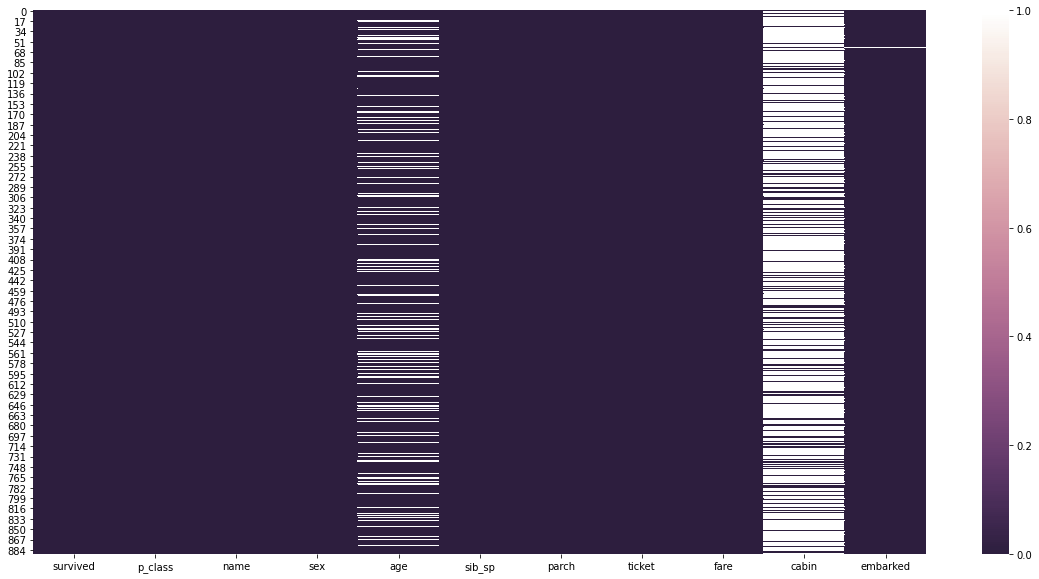

In [12]:
#%matplotlib inline
_ = plt.figure(figsize=(20, 10))

# cubehelix palette is a part of seaborn that produces a colormap
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
_ = sns.heatmap(df_train.isnull(), cmap=cmap)

And as follows for the testing set:

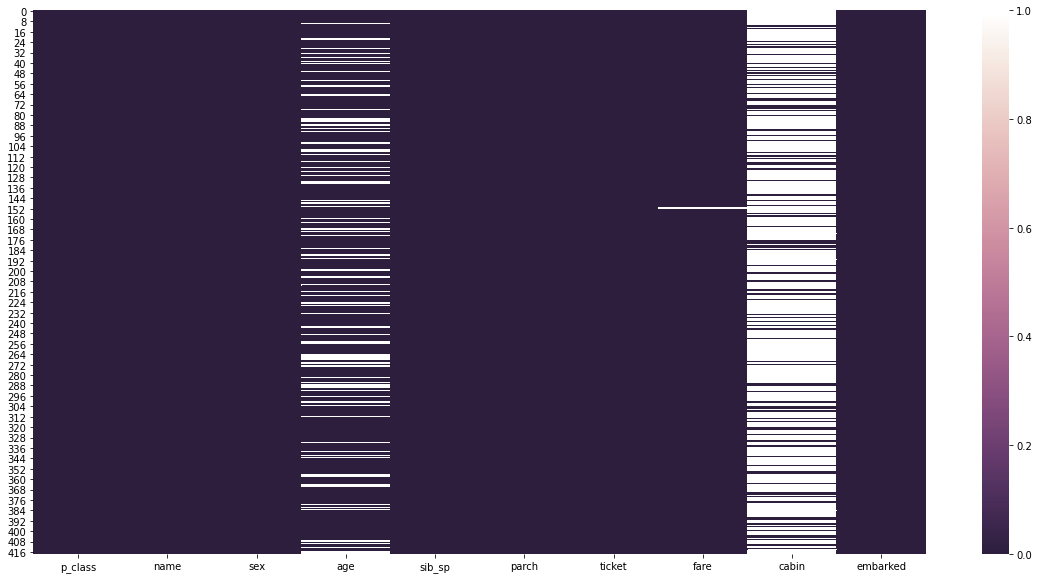

In [13]:
#%matplotlib inline
_ = plt.figure(figsize=(20, 10))

# cubehelix palette is a part of seaborn that produces a colormap
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
_ = sns.heatmap(df_test.isnull(), cmap=cmap)



From the evidence we have thus far we can conclude the following:

- The age (continuous) and cabin (categorical) variables have a significant number of missing
values.
- The cabin variable has in excess of 70% missing entries, which is substantive.
- The missing values for these variables seem to be randomly scattered throughout the data.
Without more information it is difficult to tell whether these variables are missing at
random or for some systemic reason. We will do some more analysis to try and ascertain this.

It is important for us to decide on a missing value replacement strategy for age and cabin.
The other variables have an insignficant number of missing values and hence simple
imputation will be performed.

We will start by analysing the distributions for age first to get a feel for the data.

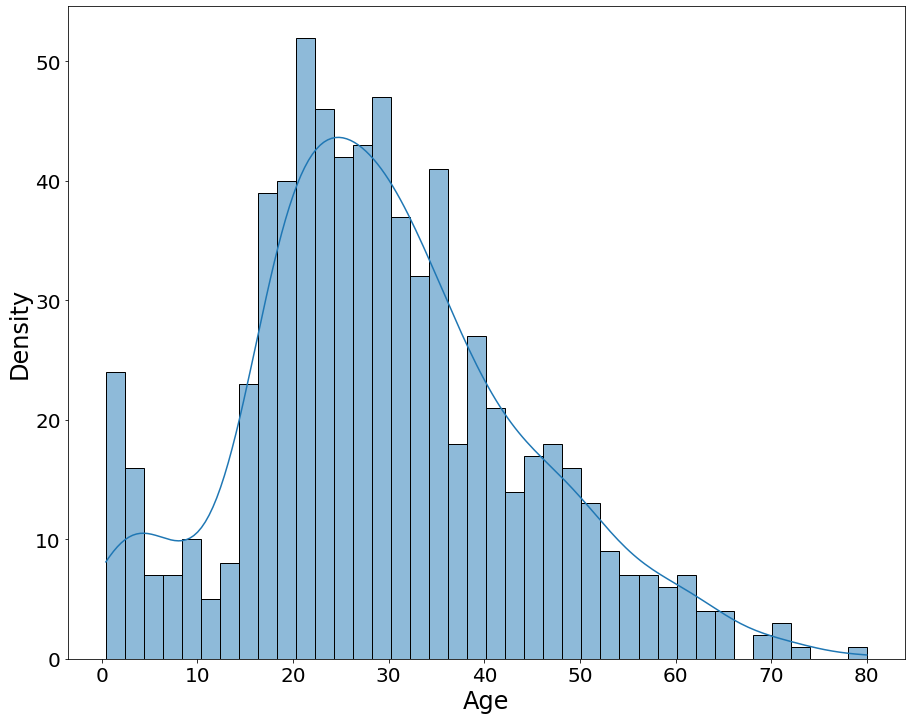

In [14]:
# Continuous density plot
fig_missing, axes = plt.subplots(1, 1, figsize=(15, 12))

# Plot frequency plot/ histogram
_ = sns.histplot(x="age", kde=True, data=df_train, ax=axes, bins=40);
_ = axes.set(xlabel="Age", ylabel='Density');
axes.xaxis.label.set_size(24)
axes.yaxis.label.set_size(24)
axes.tick_params('y', labelsize = 20);
axes.tick_params('x', labelsize = 20);

## Continuous density plot
#fig_missing, axes = plt.subplots(1, 1, figsize=(15, 12))
#
## Plot frequency plot/ histogram
#_ = sns.histplot(x="age", kde=True, data=df_test, ax=axes, bins=40);
#_ = axes.set(xlabel="Age", ylabel='Density');
#axes.xaxis.label.set_size(24)
#axes.yaxis.label.set_size(24)
#axes.tick_params('y', labelsize = 20);
#axes.tick_params('x', labelsize = 20);
#

In [15]:
print("Age summary statistics (training set):\n")
print(df_train['age'].describe())
print("\nAge summary statistics (testing set):\n")
print(df_test['age'].describe())

Age summary statistics (training set):

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

Age summary statistics (testing set):

count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: age, dtype: float64


The age variable is similarly distributed for both the training and test set i.e. there is a
 skew to the right with a slight bump on the left for lower ages. Maximum age was 80 and
 minimum age was around 2 months.

High level analysis does not seem to show any specific problematic values within either set
of data.

Next we consider whether there is correlation between missing age values and the outcome
variable i.e. survival. There are a significant number of missing age values, and if the
missing values are correlated with the outcome we should consider a more complex mechanism
for missing value substitution such as multiple imputation.

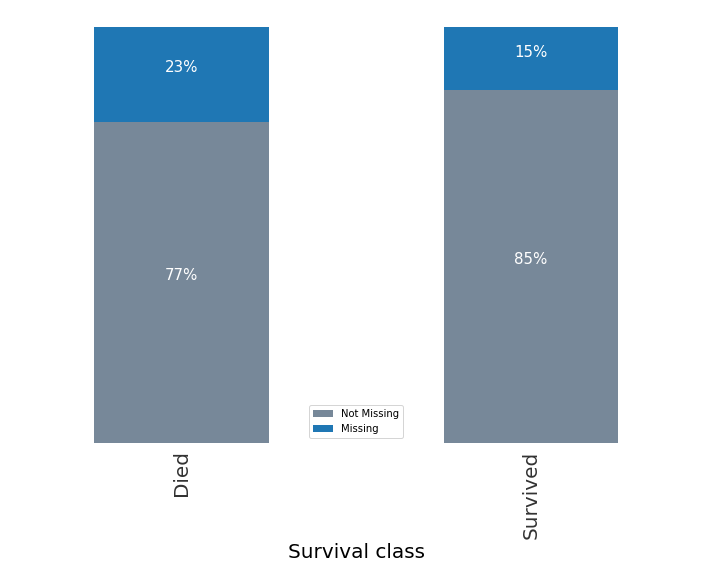

In [16]:
fig_age, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), squeeze=False)
legend_labels = ['Died', 'Survived']
colors = ["lightslategrey", "#1F77B4"]

df_train['age_missing'] = df_train.apply(lambda row: 1 if np.isnan(row['age']) else 0, axis=1)

age_missing_stacked = df_train.loc[:, ["survived", "age_missing"]]
age_missing_stacked.index.name = "passenger_num"
ctable_survival_missing = pd.crosstab(age_missing_stacked.survived, age_missing_stacked
                         .age_missing, colnames=["Missing Age"], rownames=["Survived"])
ctable_survival_missing_perc = pd.crosstab(age_missing_stacked.survived, age_missing_stacked
                         .age_missing, colnames=["Missing Age"], rownames=["Survived"],
                                           normalize="index")

#ctable_survival_missing.columns = ["Not Missing", "Missing"]
#ctable_survival_missing["Survived"] = ["Died", "Survived"]
#ctable_survival_missing = ctable_survival_missing.set_index("Survived")
#print(ctable_survival_missing)

ctable_survival_missing_perc.columns = ["Not Missing", "Missing"]
ctable_survival_missing_perc["Survived"] = ["Died", "Survived"]
ctable_survival_missing_perc = ctable_survival_missing_perc.set_index("Survived")

axs = plt.gca()
axs.set_frame_on(False)
#age_miss_stack = ctable_survival_missing.plot.bar(stacked=True, ax=axs, color=colors)
age_miss_stack = ctable_survival_missing_perc.plot.bar(stacked=True, ax=axs, color=colors)
_ = plt.xlabel('Survival class', fontsize=20)
#_ = plt.ylabel('Percentage Missing', fontsize=20)
_ = plt.xticks([0, 1], legend_labels, fontsize=15, alpha=0.8)
_ = plt.xticks(fontsize=20)
#_ = plt.yticks(fontsize=20)

# remove all the ticks (both axes), and tick labels on the Y axis
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False,
                labelbottom=True)

# Bit of a hack - TODO, clean up here.
#totals = ctable_survival_missing.iloc[:,0] + ctable_survival_missing_.iloc[:,1]
totals = ctable_survival_missing_perc.iloc[:,0] + ctable_survival_missing_perc.iloc[:,1]
#tot_arr = totals.to_numpy()

for i, rec in enumerate(age_miss_stack.patches):
    height = rec.get_height()
    j = i//2
    _ = age_miss_stack.text(rec.get_x() + rec.get_width() / 2,
              rec.get_y() + height / 2,
              "{:.0f}%".format(height/totals[j]*100),
              ha='center',
              va='bottom',
              color="w",
              fontsize = 15)

plt.tight_layout()

We observe that there is a larger proportion of missing values in the group of individuals
that died compared to the survival group, which suggests correlation between the
missing values and outcome variable (survival).

We will now perform a Chi-Squared test for independence to determine whether there is
correlation between missing age values and survival.

In [17]:
survived = df_train.loc[df_train["survived"] == 1,:]
died = df_train.loc[df_train["survived"] == 0,:]

survived_cont = survived["age_missing"].value_counts(normalize=False)
died_cont = died["age_missing"].value_counts(normalize=False)

_ = survived_cont.rename("survived", inplace=True)
_ = died_cont.rename("died", inplace=True)

#cont_table = pd.concat([survived_cont, died_cont], axis=1)

print(ctable_survival_missing)

#stat, p, dof, expected = chi2_contingency(cont_table)
stat, p, dof, expected = chi2_contingency(ctable_survival_missing)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')



Missing Age    0    1
Survived             
0            424  125
1            290   52
dof=1
[[439.93939394 109.06060606]
 [274.06060606  67.93939394]]
probability=0.950, critical=3.841, stat=7.106
Dependent (reject H0)
significance=0.050, p=0.008
Dependent (reject H0)


We can see from the results of the Chi-Squared test that the missing values in the age data
is strongly correlated with the outcome of survival (p=0.008).

This suggests strongly that we will have to take care when imputing values for age i.e.
inaccurate imputation might lead to an adverse effect on model accuracy. It is therefore
important to ensure that missing values are imputed as accurately as possible, especially
taking other variables into account i.e. missing values in particular groupings of values
might have strong correlation with the response. An advance technique such as multiple
imputation (MICE) or another predictive model such as K-Nearest Neighbour (KNN) is required
to ensure age is imputed correctly for these sub-groupings of values.

This also indicates that we could use the missing values later during feature engineering
and assess possibility of improved model performance based on additional variables built
using the missing value information.

Next we will look at the distribution of missing age values in relation to the other
variables to gain more insight into the missing values. We start with the continuous variables
and therefore we consider the fare variable first. We start with some simple distribution
plots (histograms).

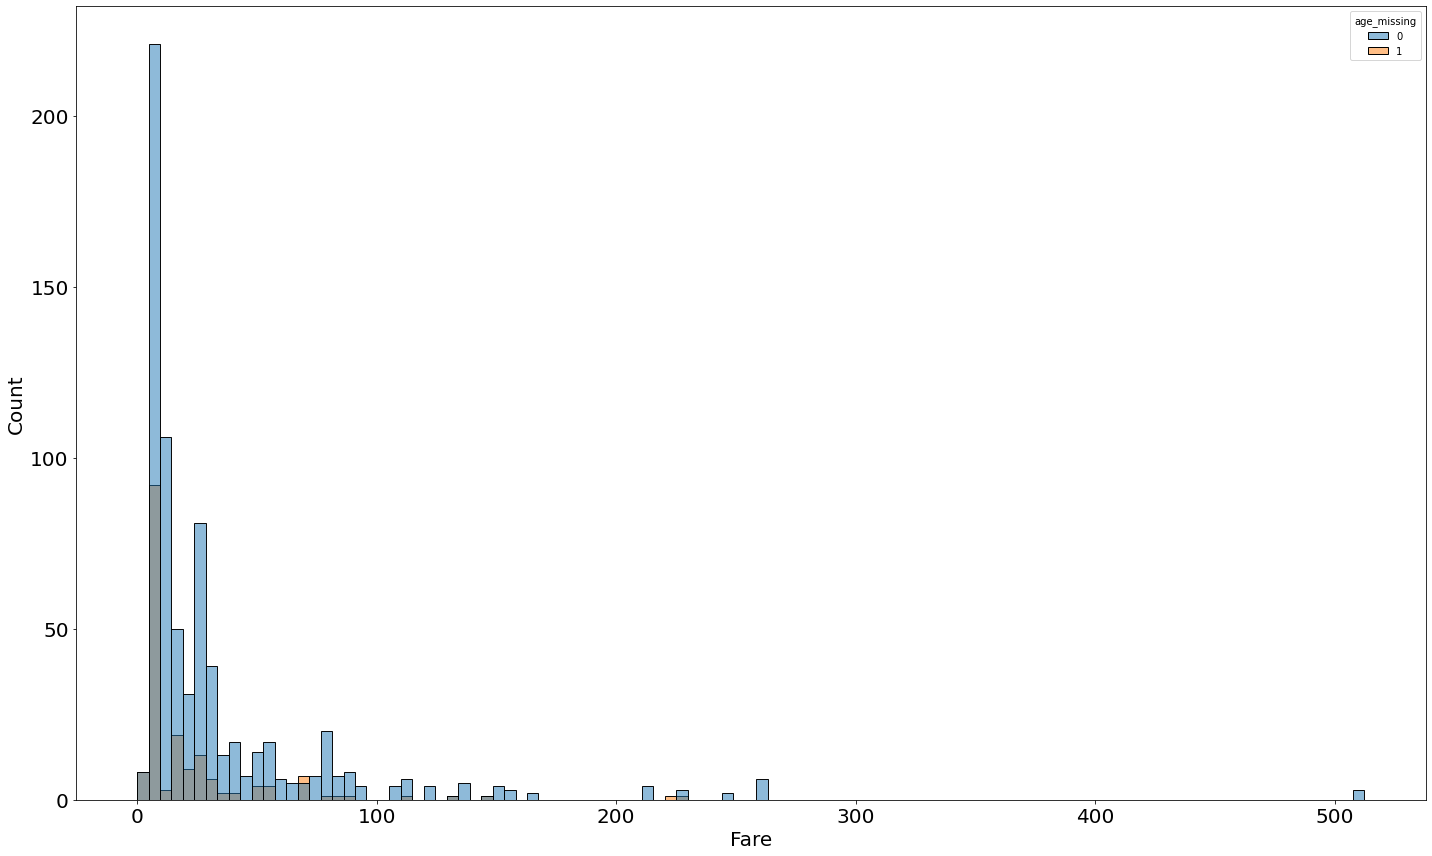

In [18]:
fig_age, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12), squeeze=False)

ax1 = sns.histplot(data = df_train, x = "fare", hue = "age_missing", ax=axes[0][0],
                   legend=True)

_ = plt.xlabel('Fare', fontsize=20)
_ = plt.ylabel('Count', fontsize=20)
_ = plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)
#ax1.legend.set_title("Missing Age")

plt.tight_layout()

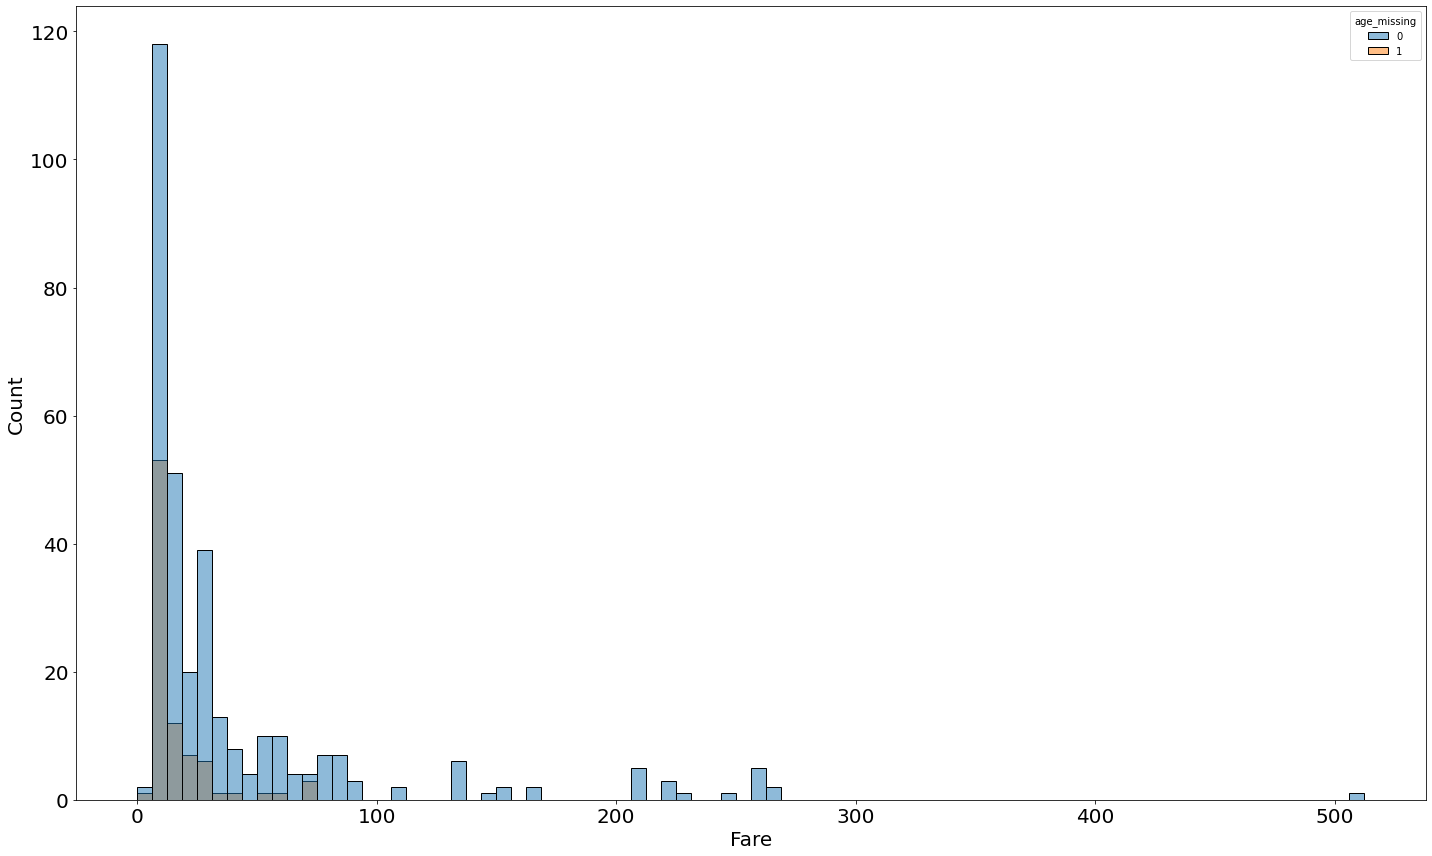

In [19]:
fig_age, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12), squeeze=False)

df_test['age_missing'] = df_test.apply(lambda row: 1 if np.isnan(row['age']) else 0, axis=1)
_ = sns.histplot(data = df_test, x = "fare", hue = "age_missing", ax=axes[0][0])

_ = plt.xlabel('Fare', fontsize=20)
_ = plt.ylabel('Count', fontsize=20)
_ = plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)
plt.tight_layout()

It is evident by inspection that the number of missing age values is higher for lower fares
in both the testing and training datasets. We now look at the same data plotted on
histograms to further explore the relationship between missing values and fare. We now
however add another dimension in that we also consider survival rate as an additional factor.

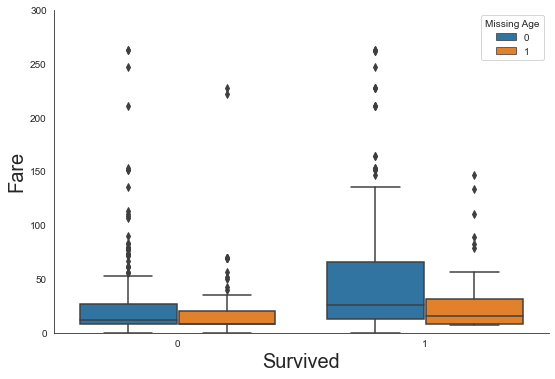

In [20]:
sns.set_style("white")
ax = sns.catplot(x="survived", y="fare", hue="age_missing", kind="box", data=df_train,
                 height = 5, aspect = 1.5, legend=False)
_ = ax.set(ylim=(0, 300))
_ = plt.xlabel('Survived', fontsize=20)
_ = plt.ylabel('Fare', fontsize=20)
_ = plt.legend(title='Missing Age')
plt.show()

It must be noted that we adapted the y-axis to cut off outlier values above 300. There were
a few values clustered at approximately 500.

The boxplots shows the same pattern we observed when considering the histograms i.e. the
distribution of fare values is different for the missing and non-missing (age) groups. For the
missing age group values are concentrated around smaller fare values.

Additionally and interestingly this plot also shows that when taking survival into account
the effect is enlarged i.e. for those who survived and paid higher fares age is typically
not missing.

At this point we could do a correlation test between missing values and fare by means of
using a logistic regression. We however leave as a later exercise as we have enough evidence
to include fare in any imputation method used to impute missing values.

Next we look at the categorical variables. We start with passenger class travelled first.

Missing Age        0    1
Passenger Class          
1                186   30
2                173   11
3                355  136


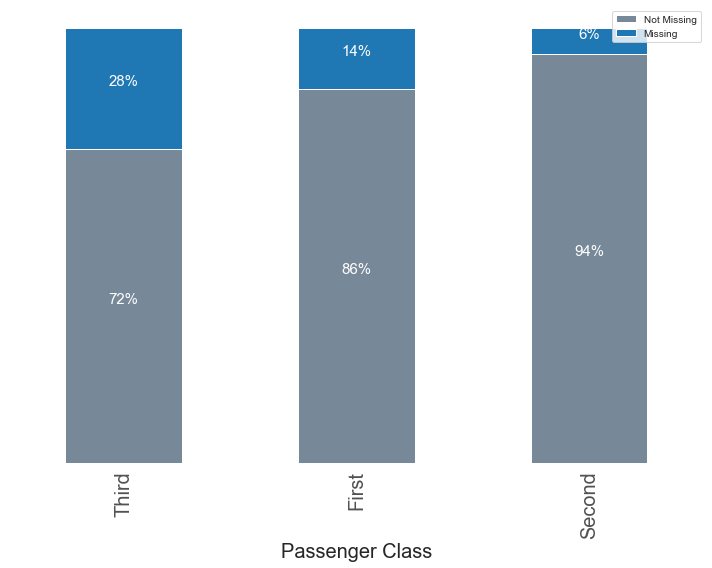

In [21]:
sns.set_style("white")
fig_age, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), squeeze=False)
legend_labels = ['Third', 'First', 'Second']
colors = ["lightslategrey", "#1F77B4"]

age_pclass_stacked = df_train.loc[:, ["p_class", "age_missing"]]
age_pclass_stacked.index.name = "passenger_num"
ctable_pclass_missing = pd.crosstab(age_pclass_stacked.p_class, age_pclass_stacked
                         .age_missing, colnames=["Missing Age"], rownames=["Passenger Class"])
ctable_pclass_missing_perc = pd.crosstab(age_pclass_stacked.p_class, age_pclass_stacked
                         .age_missing, colnames=["Missing Age"], rownames=["Passenger Class"],
                                           normalize="index")

#ctable_pclass_missing.columns = ["Not Missing", "Missing"]
#ctable_pclass_missing["Passenger Class"] = ["First", "Second", "Third"]
#ctable_pclass_missing = ctable_pclass_missing.set_index("Passenger Class")
#ctable_pclass_missing = ctable_pclass_missing.sort_values(by= 'Missing', axis=0,
#                                                          ascending=False)
print(ctable_pclass_missing)

ctable_pclass_missing_perc.columns = ["Not Missing", "Missing"]
ctable_pclass_missing_perc["Passenger Class"] = ["First", "Second", "Third"]
ctable_pclass_missing_perc = ctable_pclass_missing_perc.set_index("Passenger Class")
ctable_pclass_missing_perc = ctable_pclass_missing_perc.sort_values(by= 'Missing', axis=0,
                                                          ascending=False)

axs = plt.gca()
axs.set_frame_on(False)

age_pclass_stack = ctable_pclass_missing_perc.plot.bar(stacked=True, ax=axs, color=colors)
_ = plt.xlabel('Passenger Class', fontsize=20)
#_ = plt.ylabel('Percentage Missing', fontsize=20)
_ = plt.xticks([0, 1, 2], legend_labels, fontsize=15, alpha=0.8)
_ = plt.xticks(fontsize=20)
#_ = plt.yticks(fontsize=20)

# remove all the ticks (both axes), and tick labels on the Y axis
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False,
                labelbottom=True)

# Bit of a hack - TODO, clean up here.
totals = [ctable_pclass_missing_perc.iloc[0,:].sum(), ctable_pclass_missing_perc.iloc[1,:].sum(),
          pd.Series(ctable_pclass_missing_perc.iloc[2,:]).sum()]

for i, rec in enumerate(age_pclass_stack.patches):
    height = rec.get_height()
    j = i%3
    bar_height = height/totals[j]*100
    #print ("Debug\n j: {}\nheight: {}\ntotals: {}\n".format(j, height, totals[j]))
    _ = age_pclass_stack.text(rec.get_x() + rec.get_width()/2,
              rec.get_y() + height/2,
              "{:.0f}%".format(bar_height),
              ha='center',
              va='bottom',
              color="w",
              fontsize = 15)

plt.tight_layout()

It is evident by inspection that the number of missing age values is higher in the third
passenger class than the other two classes.

Next we perform a Chi-Squared test of correlation.

In [22]:
#stat, p, dof, expected = chi2_contingency(cont_table)
stat, p, dof, expected = chi2_contingency(ctable_pclass_missing)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')



dof=2
[[173.09090909  42.90909091]
 [147.44781145  36.55218855]
 [393.46127946  97.53872054]]
probability=0.950, critical=5.991, stat=46.063
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


We can see from the results of the Chi-Squared test that passenger class is strongly
correlated with a value being missing (p=0.000).

At this point we can conclude that missing values are correlated with several key variables,
which leads us to conclude that replacing missing values by using predictive model is
necessary. We will use KNN imputation as it is frequently used for this type of substitution.
We won't use MICE as we will impute one variable only i.e. age. MICE is overkill in this
instance as its utility derives from the ability to impute several values concurrently. The
other missing variables in our dataset we will deal with manually.

We will impute missing values later in this analysis at the time when we split the datasets
into training and testing sets in order to avoid data leakage between training and testing
sets. For now, we will continue with our EDA.



The number of null values after missing values have been replaced in the test set is:

In [23]:
# Replace missing values for test set
df_test = df_test.copy()
median = df_test['age'].median()
df_test['age'].fillna(median, inplace=True)
print("Number of null values in age column: {}".format(df_test['age'].isnull().sum()))

median = df_test['fare'].median()
df_test['fare'].fillna(median, inplace=True)
print("Number of null values in fare column: {}".format(df_test['fare'].isnull().sum()))
print("Dataframe dimension: {}".format(df_test.shape))
df_test = df_test.copy()

Number of null values in age column: 0
Number of null values in fare column: 0
Dataframe dimension: (418, 11)


We observe that the null values have been removed. We now have a dataset ready for further analysis -
albeit a bit of a black box hack :) We will now do some very limited EDA just to get a feel for the data
as previously discussed.

<div class="alert alert-block alert-info">
<b>Exploration of data</b>
</div>

We start by looking at the number of unique records per variable.

In [24]:
print(df_train.nunique())

survived         2
p_class          3
name           891
sex              2
age             88
sib_sp           7
parch            7
ticket         681
fare           248
cabin          147
embarked         3
age_missing      2
dtype: int64


There are no columns with only one value. We therefore retain all columns for ML purposes as there is
enough variability to warrant using the data. There are many variables with fewer than 10 levels which
could be considered as categorical. Based on our initial assessment of the data we will work with
levels of measurement for the data as follows:

- p_class (ordinal) - we will revisit type of encoding later
- sex (binary) - recode (female - yes or no)
- age (continuous)
- sib_sp (ordinal) - check correlation - revisit encoding
- parch (ordinal) - check correlation - revisit encoding
- fare (continuous)
- embarked (nominal) - recode (one hot encode) - probably categorical

At this point we have nominal and binary categorical data. We need to One Hot Encode one variable i.e.
embarked as it is categorical and non-binary. We will leave the ordinal data as is for the initial
analysis i.e. label encode it. Next we look at the distribution of the data.

We start by separating continuous and categorical variables for further high level analysis before
running our quick and dirty models.

In [25]:
# Separate continuous and categorical variables
names_con = ('fare', 'age')
names_con_plot = ('survived', 'fare', 'age')
names_cat = ('survived', 'p_class', 'sex', 'sib_sp', 'parch', 'embarked')
names_cat_test = ('p_class', 'sex', 'sib_sp', 'parch', 'embarked')

df_train_con = df_train.loc[:, names_con]
df_train_con_plot = df_train.loc[:, names_con_plot]
df_train_cat = df_train.loc[:, names_cat]

df_test_con = df_test.loc[:, names_con]
df_test_cat = df_test.loc[:, names_cat_test]

# Plotting label dictionary
plot_con = [('fare', 'Fare'),
            ('age', 'Age')]
plot_con_plot = [('survived', 'Survived'),
            ('fare', 'Fare'),
            ('age', 'Age')]
plot_cat = {'survived': ['Died', 'Survived'],
            'p_class': ['3rd', '1st', '2nd'],
            'sex': ['Male', 'Female'],
            'sib_sp': ['0', '1', '2', '4', '3', '8', '5'],
            'parch': ['0', '1', '2', '3', '5', '4', '6'],
            'embarked': ['Southampton', 'Cherbourg', 'Queenstown']}
plot_cat_plot = {'survived': 'Survival Rate',
            'p_class': 'Passenger Class Travelled',
            'sex': 'Gender',
            'sib_sp': '# Siblings or spouses',
            'parch': '# Parents or children',
            'embarked': 'Port of Embarkation'}

### High level overview


We observe that we have two candidates for continuous variables here (age and fare). With all the
categorical variables present, it is likely that a tree model would be better suited to this problem
unless significant feature engineering on categorical features is performed to ensure features are
optimally encoded, transformed and scaled for a linear model or neural network.

Let's continue with the high level analysis.

The overall survival rate was as follows (based on the training dataset):

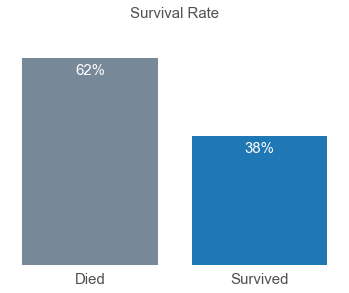

In [26]:
_ = plt.figure()

# Plot outcome counts.a
outcome_counts = df_train_cat['survived'].value_counts(normalize = True)
legend_labels = ['Died', 'Survived']

# change the background bar colors to be light grey
bars = plt.bar(outcome_counts.index, outcome_counts.values, align='center', linewidth=0,
               color='lightslategrey')
# make one bar, the survived bar, a contrasting color
bars[1].set_color('#1F77B4')

# soften all labels by turning grey
_ = plt.xticks(outcome_counts.index, legend_labels, fontsize=15, alpha=0.8)
_ = plt.title('Survival Rate', fontsize=15, pad=30, alpha=0.8)

# remove all the ticks (both axes), and tick labels on the Y axis
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False,
                labelbottom=True)

# Remove the frame - my method
ax = plt.gca()
ax.set_frame_on(False)

# Remove the frame of the chart - instructor's method
#for spine in plt.gca().spines.values():
#    spine.set_visible(False)

# direct label each bar with Y axis values
for bar in bars:
    _ = plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05,
                       str(round((bar.get_height()*100))) + '%', ha='center', color='w',
                       fontsize=15)

plt.show()

The survival statistics are as follows:


In [27]:
print(df_train_cat['survived'].value_counts())
print("\n")

#print(df_train_cat['survived'].value_counts(normalize = True).mul(100).round(1).astype(str) + '%')
#print("\n")
#

0    549
1    342
Name: survived, dtype: int64




We observe that 38% of passengers survived and 62% died. These statistics correspond with the narrative on survival
rate quoted in the background information on Kaggle. There it is quoted that around 32% survived and 68% died. The
sample we are working with is thus representative of the overall population, which is important to note.

We observe that the target variable contains unbalanced classes. We need to consider revisiting the unbalanced
classes at a later stage - depending on the accuracy of our models. For now, we will forge ahead.

Next we will consider class level counts for categorical variables.

#### Categorical variable overview

Class percentages:

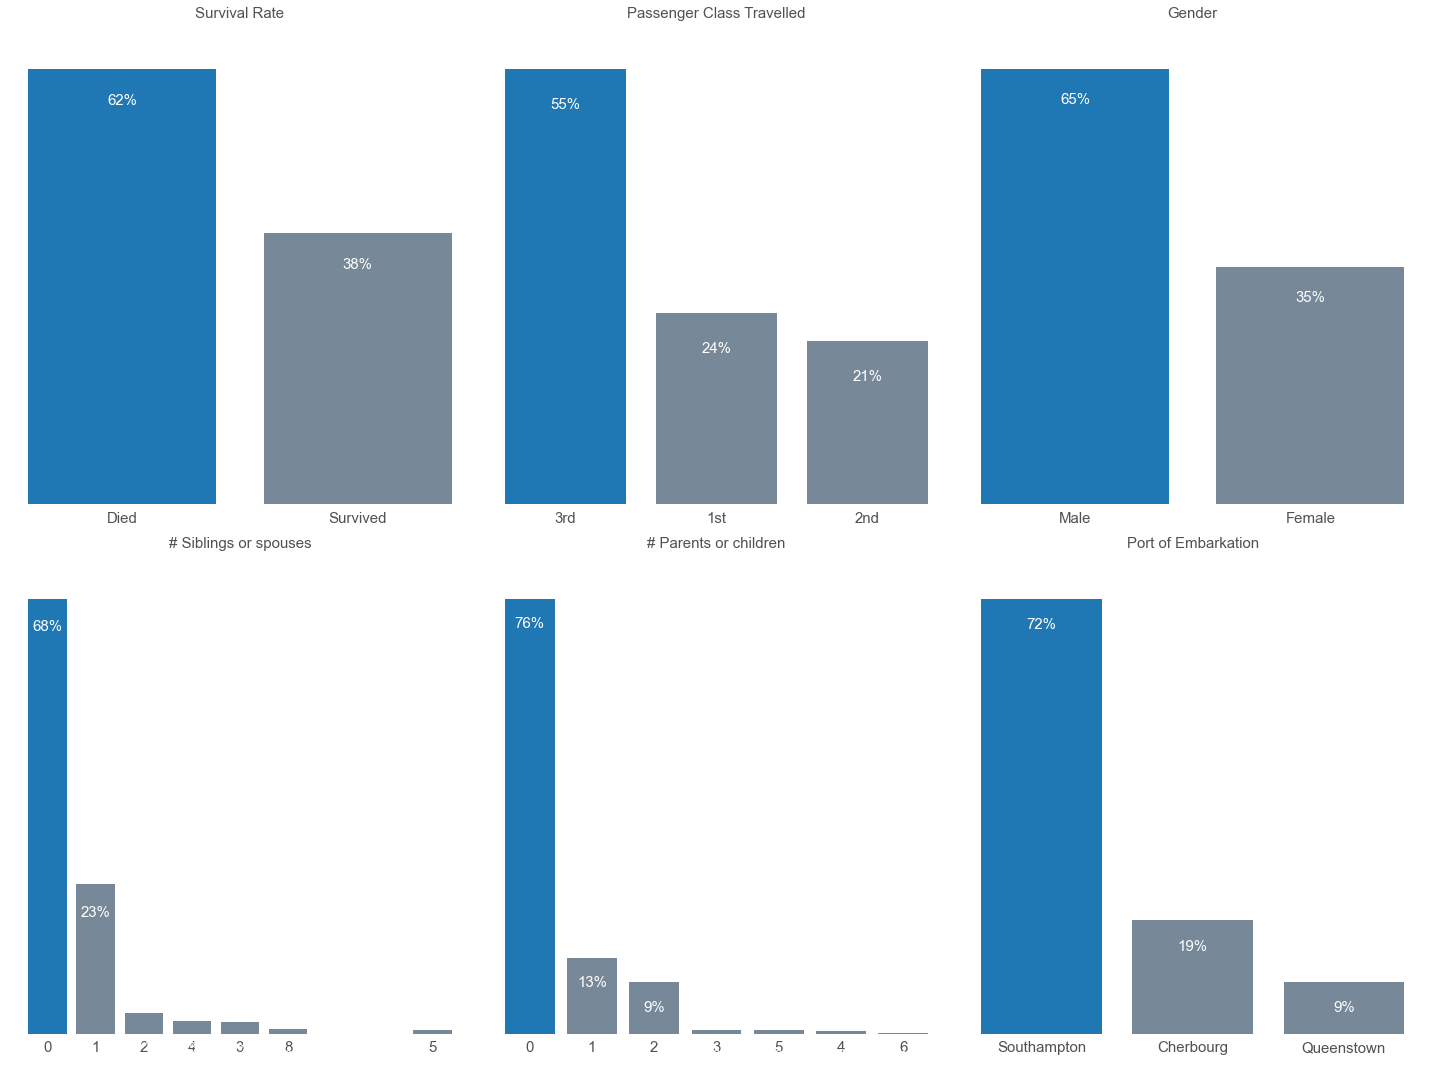

In [28]:
# Bar chart plot of categorical variables.
fig, ax = plt.subplots(2, 3, figsize=(20, 15));
base_color = '#1F77B4'
for variable, subplot in zip(names_cat, ax.flatten()):
    subplot.xaxis.label.set_size(24)
    subplot.yaxis.label.set_size(24)
    subplot.tick_params('y', labelsize = 20);
    subplot.tick_params('x', labelsize = 20);
    subplot.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False,
                        labelbottom=True)
    subplot.set_frame_on(False)

    outcome_counts = df_train_cat[variable].value_counts(normalize=True)
    bars = subplot.bar(outcome_counts.index.sort_values(), outcome_counts.values, align='center',
                       linewidth=0,
               color='lightslategrey')
    # make one bar, the highest value bar, a contrasting color
    bars[0].set_color('#1F77B4')

    plt.sca(subplot)
    _ = plt.xticks(outcome_counts.index.sort_values(), plot_cat[variable], fontsize=15, alpha=0.8)
    _ = plt.title(plot_cat_plot[variable], fontsize=15, pad=30, alpha=0.8)

    # direct label each bar with Y axis values
    for bar in bars:
        _ = plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05,
                           str(round((bar.get_height()*100))) + '%', ha='center', color='w',
                           fontsize=15)

    plt.tight_layout()


Class counts:


In [29]:
# Class level counts for categorical variables.
for variable in names_cat:
    #print(df_train_cat[variable].value_counts(normalize = True).mul(100).round(1).astype(str) +
    # '%')
    print(df_train_cat[variable].value_counts())
    print("\n")

0    549
1    342
Name: survived, dtype: int64


3    491
1    216
2    184
Name: p_class, dtype: int64


male      577
female    314
Name: sex, dtype: int64


0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: sib_sp, dtype: int64


0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: parch, dtype: int64


S    644
C    168
Q     77
Name: embarked, dtype: int64




From the categorical variables we observe that there were approximately twice as many passengers in class 3 than either
class 1 or 2. We also observe that there were nearly twice as many males as females on the Titanic. We also observe
that more than two thirds of passengers did not have any siblings on board. Likewise we observe that more than two
thirds did not have a father or child on board.

It is therefore fair to say that the majority of passengers were either couples or single travellers without children
. In the case where families did travel, the majority of families had one or two children. Very few families with
more children were on board the Titanic.

We also see that more than two thirds of passengers departed from Southampton.

Many of these variables could contribute o correlation with survival at face value e.g. it stands to reason that
preference would have been given in lifeboats to women and children, and that more affluent travellers would have had
access to better lifeboats. We will however test these hypotheses in this analysis.

#### Continuous variable overview

We start by considering the age distribution of the passengers. At this point we do some limited
EDA in that we will consider the age profiles of those who survived vs. those who died. As with
many natural phenomena we expect age to have some influence on mortality.

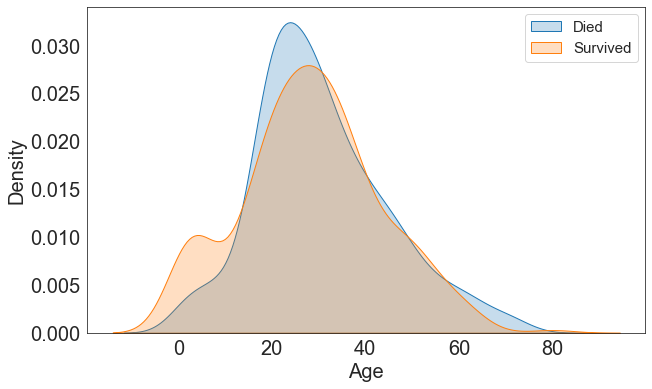

In [30]:
fig_age, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), squeeze=False)

_ = sns.kdeplot(data=df_train_con_plot.loc[(df_train_con_plot['survived'] == 0), 'age'], shade =
True, label = 'Died')
_ = sns.kdeplot(data=df_train_con_plot.loc[(df_train_con_plot['survived'] == 1), 'age'], shade =
True, label = 'Survived')
_ = plt.xlabel('Age', fontsize=20)
_ = plt.ylabel('Density', fontsize=20)
_ = plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)
_ = plt.legend(fontsize=15)
plt.show()


From the age distribution plot we can see that more children under the age of 15 survived than
died in the incident. We can see that more individuals between the ages of 20 and 40 died than
survived. We can also see that more individuals above the age of 80 survived compared to dying.

We can also see that the majority of individuals on the cruise were between the ages of 20 to 40.
There were fewer teenagers compared to children under 10. There were comparatively fewer elderly
people on board i.e. above 60.

In [31]:
# 5 number summary.
df_train_con.describe()


,fare,age
count,891.000000,714.000000
mean,32.204208,29.699118
std,49.693429,14.526497
min,0.000000,0.420000
25%,7.910400,20.125000
50%,14.454200,28.000000
75%,31.000000,38.000000
max,512.329200,80.000000


We now consider the fare distribution too. As with age, our assumption would be that fare has a
correlation with mortality too.

The fare distribution is severely skewed to the right. The kurtosis of the plot is very high with
 most values clustered closely around the median value of 14. There was a non-significant but
 relatively smaller number of fares spread between teh values of 30 and 500.

The age distribution was as previously discussed, with a minimum of 6 months and maximum of 80
years old. The distribution is fairly symmetrical with a slight skew to the right. There is a
young child bump to the left of the distribution.

We now do a more in depth visual analysis of the correlation between survival and fare and age
respectively. We do this by creating a set of Violin plots.

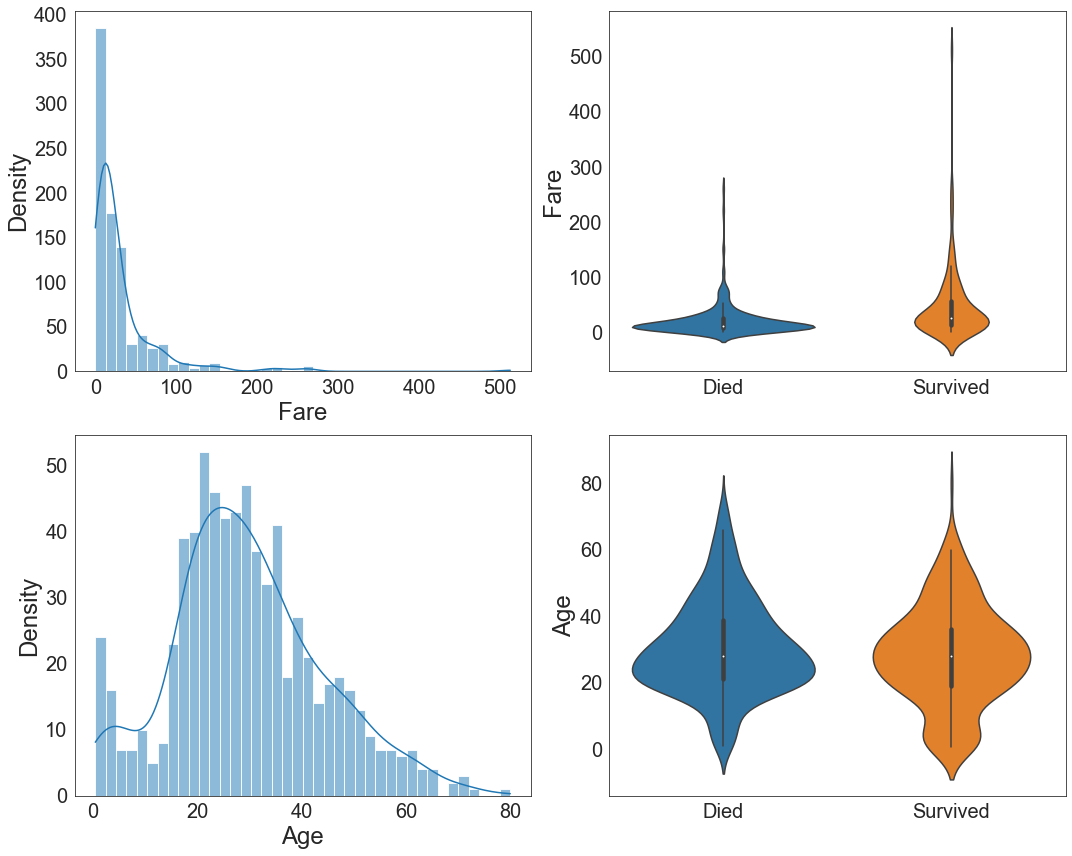

In [32]:
# Continuous density plot
fig_continuous, axes = plt.subplots(nrows=len(names_con_plot)-1, ncols=2, figsize=(15, 12))

# Plot frequency plot/ histogram
_ = sns.histplot(x=plot_con[0][0], kde=True, data=df_train_con_plot, ax=axes[0][0], bins=40);
_ = axes[0][0].set(xlabel=plot_con[0][1], ylabel='Density');
axes[0][0].xaxis.label.set_size(24)
axes[0][0].yaxis.label.set_size(24)
axes[0][0].tick_params('y', labelsize = 20);
axes[0][0].tick_params('x', labelsize = 20);

# Plot violin plot
_ = sns.violinplot(x='survived', y=plot_con[0][0], data=df_train_con_plot, ax=axes[0][1]);
_ = axes[0][1].set(xlabel='', ylabel=plot_con[0][1]);
axes[0][1].xaxis.label.set_size(24)
axes[0][1].yaxis.label.set_size(24)
axes[0][1].tick_params('y', labelsize = 20);
axes[0][1].tick_params('x', labelsize = 20);
_ = axes[0][1].set_xticklabels(['Died', 'Survived'])

# Plot frequency plot/ histogram
_ = sns.histplot(x=plot_con[1][0], kde=True, data=df_train_con_plot, ax=axes[1][0], bins=40);
_ = axes[1][0].set(xlabel=plot_con[1][1], ylabel='Density');
axes[1][0].xaxis.label.set_size(24)
axes[1][0].yaxis.label.set_size(24)
axes[1][0].tick_params('y', labelsize = 20);
axes[1][0].tick_params('x', labelsize = 20);

# Plot violin plot
_ = sns.violinplot(x='survived', y=plot_con[1][0], data=df_train_con_plot, ax=axes[1][1]);
_ = axes[1][1].set(ylabel=plot_con[1][1], xlabel='');
axes[1][1].xaxis.label.set_size(24)
axes[1][1].yaxis.label.set_size(24)
axes[1][1].tick_params('y', labelsize = 20);
axes[1][1].tick_params('x', labelsize = 20);
_ = axes[1][1].set_xticklabels(['Died', 'Survived'])

plt.tight_layout()



The violin plot for <i>fare</i> indicates that there is correlation between fare and survival as
more people paying a low fare died and chances of survival increased for higher fares, as well as
 lower fares close to zero (possibly for children travelling at very low cost).

The plot for <i>age</i> indicates a similar pattern with higher survival for children below 10
and higher mortality between ages of 20 and 40. The relative likelihood of survival increases
again around 40 years of age as you go into the older ages.

We will investigate these observations in more detail in our next Notebook.

Lastly we will look at the Box plots for both age and fare. We do this to get a better feel for
the spread of the data and the possibility of outliers. This will be important for us to consider
 whether further analysis and possible processing of variables are required in later stages.

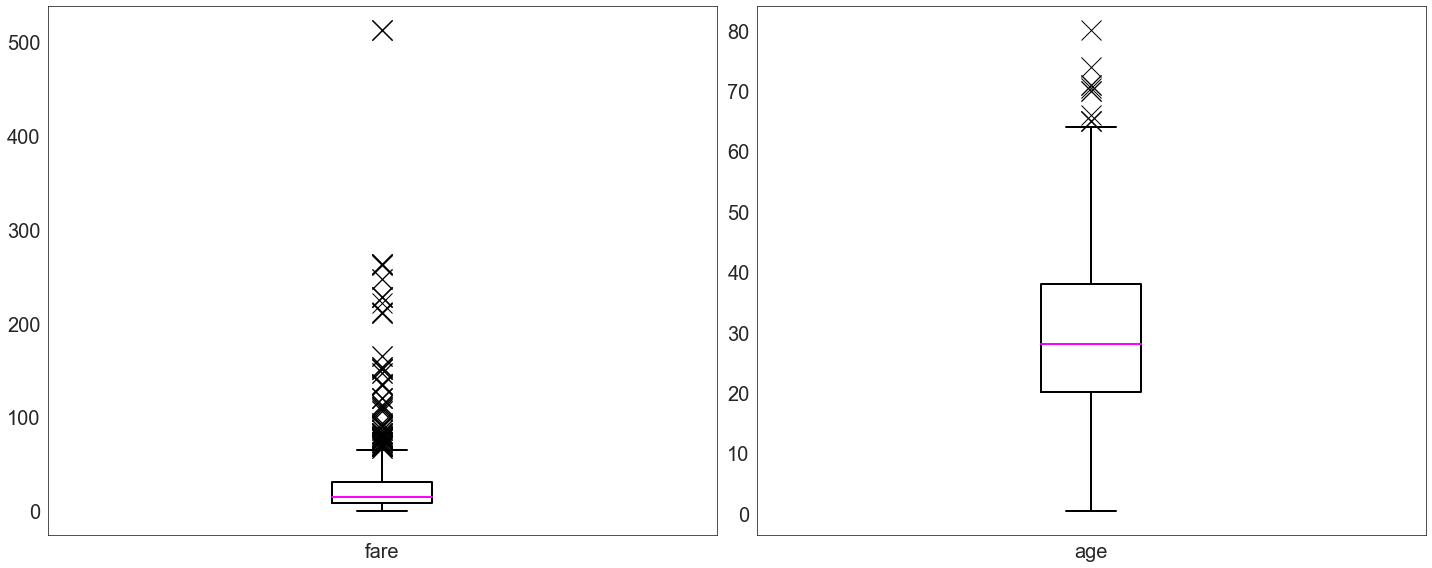

In [33]:
# Boxplot of continuous variables
medianprops = {'color': 'magenta', 'linewidth': 2}
boxprops = {'color': 'black', 'linestyle': '-', 'linewidth': 2}
whiskerprops = {'color': 'black', 'linestyle': '-', 'linewidth': 2}
capprops = {'color': 'black', 'linestyle': '-', 'linewidth': 2}
flierprops = {'color': 'black', 'marker': 'x', 'markersize': 20}

_ = df_train_con.plot(kind='box', subplots=True, figsize=(20, 8), layout=(1,2), fontsize = 20,
                      medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops,
                      capprops=capprops, flierprops=flierprops);
_ = plt.tight_layout();
_ = plt.show();


The distributions of the <i>fare</i> and <i>age</i> variables show that fare is skewed heavily to
 the right, with the median skewed to the left of the distribution as expected. The values in the
  final quintile are spread over wide area with quite a few outliers. This distribution is heavy
  tailed, as can be expected of many financial distributions. We observe that there are zero
  values, and there is a large peak in the bin containing zero. We will need to investigate this
  group of travellers as they could be different from the general population. The heavy tail and
  many outliers are also good candidates for further processing.

The <i>age</i> distribution is fairly symmetrical, with a few outliers to the right, but nothing
out of the ordinary. Most of the values are bundled symmetrically around the median of 28, which
is quite a young age for the average traveller. The large spike in ages at this interval is also
concerning and seems out of place. This will need to be further investigated.

<div class="alert alert-block alert-info">
<b>Transform variables</b>
</div>

We will now build the following models as previously discussed:

 1. Logistic regression
 2. Multi-layer Perceptron (MLP)
 3. Decision Tree
 4. Random Forest

Our strategy is to build our own <i>validation strategy</i> based on the training set for which
we have labels. We will do this by splitting this set into training and testing sets according to
a 75%/ 25% split. Any hyper-parameter optimisation will be done by using <i>cross validation</i>
on the 75% test set. The 25% testing set will be used for our final test before we apply the
results to the provided test set for submission.

We therefore now start by splitting the response and features for the training set as previously
discussed.

We will be using this dataset for all our models from here onwards. We also perform minor
transformations such as encoding the <i>sex</i> variable for test and training sets. We also One
Hot Encode the <i>embarked</i> variable. We drop one of the categories for embarked to avoid
multi-collinearity (dummy variable trap).

In [34]:
# We will now transform some variables to numeric values in order to do the ML analysis.
# These transformations would not result in data leakage, and can hence be done before we
# split the data into training and testing sets.

# Make a copy of original dataset before imputation - we need the original for further
# analysis.
df_train_trans = df_train.copy()
df_test_trans = df_test.copy()

# Creating Deck field from the first letter of the cabin field (we create a new category for
# missing, which is called M). As this is a categorical variable we will leave the missing
# value field as is.
df_train_trans['deck'] = df_train_trans['cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_test_trans['deck'] = df_test_trans['cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

#df_train_trans.head()
# Drop cabin field
df_train_trans = df_train_trans.loc[:,['survived', 'p_class', 'name', 'sex',
 'age', 'sib_sp', 'parch', 'ticket', 'fare', 'embarked', 'deck']]
#print("Dataframe dimension: {}".format(df_train.shape))

df_train_trans.head()

# Transform sex variable - don't need one hot encoding as variable is binary
df_train_trans['sex'] = df_train_trans['sex'].apply(lambda x: 1 if x == 'female' else 0)

# Same transformation for test set - don't need one hot encoding as variable is binary
df_test_trans['sex'] = df_test_trans['sex'].apply(lambda x: 1 if x == 'female' else 0)

# Transform embarked variable training set
#ohe = OneHotEncoder(categories='auto', drop='first', variables=['embarked', 'deck'])
#ohe.fit(df_train_trans)
#df_train_trans = ohe.transform(df_train_trans)
#df_test_trans = ohe.transform(df_test_trans)
#df_train_trans.head()

#df_ohe = pd.DataFrame(train_trans, columns = ohe.get_feature_names())
#df_train_trans = pd.concat([df_train_trans.loc[:, ['survived', 'p_class', 'name', 'sex',
# 'age', 'sib_sp', 'parch', 'ticket', 'fare', 'deck']], df_ohe], axis=1)

## Transform embarked variable training set
#ohe = OneHotEncoder(categories='auto', drop='first')
#train_trans = ohe.fit_transform(df_train_trans[['embarked', 'deck']])
#df_ohe = pd.DataFrame(train_trans, columns = ohe.get_feature_names())
#df_train_trans = pd.concat([df_train_trans.loc[:, ['survived', 'p_class', 'name', 'sex',
# 'age', 'sib_sp', 'parch', 'ticket', 'fare', 'deck']], df_ohe], axis=1)
#
#df_train_trans.head()

# Replace embarked with mode training set - no values missing in test set, so not required
# to further impute. Some leakage takes place here, but only one value so not important.
train_emb_mode = df_train_trans['embarked'].mode()
df_train_trans['embarked'].fillna(train_emb_mode.iloc[0], inplace=True)

categorical_cols = ['embarked', 'deck']
# Transform embarked variable training set
#ohe = OneHotEncoder(categories='auto', drop='first')
#train_trans = ohe.fit_transform(df_train_trans[categorical_cols])
#data_hot_encoded = pd.DataFrame(train_trans, index=df_train_trans.index)

data_hot_encoded = pd.get_dummies(df_train_trans, columns = categorical_cols, drop_first=True)

data_hot_encoded.head()

#df_ohe = pd.DataFrame(train_trans, columns = ohe.get_feature_names(input_features=categorical_cols))
#df_train_trans = pd.concat([df_train_trans.loc[:, ['survived', 'p_class', 'name', 'sex',
# 'age', 'sib_sp', 'parch', 'ticket', 'fare', 'deck']], df_ohe], axis=1)

## Transform embarked variable for test set
##ohe2 = OneHotEncoder(categories='auto', drop='first')
#test_trans = ohe.fit_transform(df_test_trans.embarked.values.reshape(-1, 1)).toarray()
#df_ohe2 = pd.DataFrame(test_trans, columns = ohe.get_feature_names())
#df_test_trans = pd.concat([df_test_trans.loc[:, ['p_class', 'name', 'sex',
# 'age', 'sib_sp', 'parch', 'ticket', 'fare', 'deck']], df_ohe2], axis=1)
#
#df_train_trans.head()
#
## Transform deck variable training set using OHE - TODO, replace with ordinal encoding
##ohe = OneHotEncoder(categories='auto', drop='first')
#train_trans = ohe.fit_transform(df_train_trans.deck.values.reshape(-1, 1)).toarray()
#df_ohe = pd.DataFrame(train_trans, columns = ohe.get_feature_names())
#df_train_trans = pd.concat([df_train_trans.loc[:, ['survived', 'p_class', 'name', 'sex',
# 'age', 'sib_sp', 'parch', 'ticket', 'fare', 'deck', 'x0_Q', 'x0_S']], df_ohe], axis=1)
#
## Transform deck variable testing set using OHE - TODO, replace with ordinal encoding
##ohe2 = OneHotEncoder(categories='auto', drop='first')
#test_trans = ohe.fit_transform(df_test_trans.deck.values.reshape(-1, 1)).toarray()
#df_ohe2 = pd.DataFrame(test_trans, columns = ohe.get_feature_names())
#df_test_trans = pd.concat([df_test_trans.loc[:, ['p_class', 'name', 'sex',
# 'age', 'sib_sp', 'parch', 'ticket', 'fare', 'deck', 'x0_Q', 'x0_S']], df_ohe2], axis=1)
#
#df_train_trans.head()
#

#print('Missing: %d' % sum(isnan(df_train_trans).flatten()))

# Define imputer
#imputer = IterativeImputer()
## fit on the dataset
#imputer.fit(df_train_trans)
## transform the dataset
#df_train_trans = imputer.transform(df_train_trans)
## summarize total missing
#print('Missing: %d' % sum(isnan(df_train_trans).flatten()))




,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,embarked,deck
passenger_num,,,,,,,,,,,
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,M
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,M
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,M


,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,embarked_Q,embarked_S,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_M,deck_T
passenger_num,,,,,,,,,,,,,,,,,,,
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0,1,0,0,0,0,0,0,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,0,0,0,1,0,0,0,0,0,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,0,0,0,0,1,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,0,1,0,1,0,0,0,0,0,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0,1,0,0,0,0,0,0,1,0


In [35]:
# Group response values to form binary response
y = df_train.loc[:, 'survived']

# Split data into features (X) and response (y)
X = df_train.loc[:, ('p_class', 'sex', 'age', 'sib_sp', 'parch', 'fare', 'embarked')]
df_test = df_test.loc[:, ('p_class', 'sex', 'age', 'sib_sp', 'parch', 'fare', 'embarked')]

# Put the response y into an array
y = np.ravel(y)

# Transform sex variable
X['sex'] = X['sex'].apply(lambda x: 1 if x == 'female' else 0)

# Same transformation for test set.
df_test['sex'] = df_test['sex'].apply(lambda x: 1 if x == 'female' else 0)

# Transform embarked variable
ohe = OneHotEncoder(categories='auto', drop='first')
Xd = ohe.fit_transform(X.embarked.values.reshape(-1, 1)).toarray()
df_ohe = pd.DataFrame(Xd, columns = ohe.get_feature_names())

X = pd.concat([X.loc[:, ['p_class', 'sex', 'age', 'sib_sp', 'parch', 'fare']], df_ohe], axis=1)

# Transform embarked variable for test set
ohe2 = OneHotEncoder(categories='auto', drop='first')
Xd2 = ohe2.fit_transform(df_test.embarked.values.reshape(-1, 1)).toarray()
df_ohe2 = pd.DataFrame(Xd2, columns = ohe.get_feature_names())

df_test = pd.concat([df_test.loc[:, ['p_class', 'sex', 'age', 'sib_sp', 'parch', 'fare']],
                     df_ohe2], axis=1)

ValueError: Input contains NaN

#### Split and scale the data

We now split the data into training and test sets according to a 75/ 25% split. We then scale the
 data by using the Standard Scaler to account for the differences between continuous and 
 categorical variable scales of measurement. We will refine this process in our next Notebook. 
 We also scale the final test set provided for submission of our results. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
#print('Percentage holdout data: {}%'.format(round(100*(len(X_test)/len(X)),0)))




# Replace fare in test set with median from train set - to prevent data leakage.
median = df_train_trans['fare'].median()
df_test_trans['fare'].fillna(median, inplace=True)

# Replace missing values for training set
print("Number of null values in age column: {}".format(df_train['age'].isnull().sum()))
print("Number of null values in embarked column: {}".format(df_train['embarked'].isnull().sum()))


# Scale data
scaler = StandardScaler()

# Fit on training data set
_ = scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Apply to test data (training)
X_test = scaler.transform(X_test)

# Apply to final test data
df_test = scaler.transform(df_test)


<div class="alert alert-block alert-info">
<b>Build models</b>
</div>

We can now start building our first model, yay! We build and test a naive logistic regression 
model - without any transformations or optimisations.

The objective is to ascertain the strength of association between features and responses on 
unprocessed data. 

#### Naive Logistic Regression

In [ ]:
# Initial model
log_reg = LogisticRegression(max_iter=2000000, fit_intercept = False)

# Probability scores for test set
y_score_init = log_reg.fit(X_train, y_train).decision_function(X_test)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_score_init)

plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

In [ ]:
y_pred = log_reg.predict(X_test)
# Accuracy before model parameter optimisation
cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

As can be seen from the accuracy measurements the baseline model performs exceptionally well. A
C-statistic (Area Under the Curve - AUC) of 86% on data that has only been scaled without any
transformation is an excellent result.

This result is somewhat surprising given our high level EDA outcomes which showed only slight
correlation between age and fare and survival rate.

Based on this result it is evident that there must be stronger correlation for at least a few of
the categorical variables. Our more in-depth analysis will hopefully shed more light on this!

The model has a precision of 83% which is high. At a given threshold the ability to correctly
predict sub-population survival rates would in all likelihood be very good for this model.

The sensitivity of 68% is not very high, but is to be expected for this type of problem. Out of
the entire population 32% of survivors will not be identified. For some applications this might
be problematic.

We will now investigate correlation amongst the predictors further, but first, we will build a
few more models to further investigate the raw strength of signal in the data.

Next we build a simple Multi Layer Perceptron using scikit-learn to see if it does any better
than the Logistic Regression.

#### Naive MLP

In [ ]:
# Fit and check MSE before regularisation
mlp_reg = MLPClassifier(max_iter=50000, solver="adam", activation="tanh", hidden_layer_sizes=(5, 5),
                    random_state=1)
mlp_reg = mlp_reg.fit(X_train, y_train)

# Predict
y_pred = mlp_reg.predict(X_test)

# Accuracy before model parameter optimisation
print ("Accuracy Score: %0.5f" % accuracy_score(y_pred,y_test))

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)

plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

# Accuracy before model parameter optimisation
cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

The naive MLP has an accuracy score of 82% which is higher than the accuracy of the Logistic
Regression of 77%.

The C-Statistic is however lower, which is surprising. Care should be taken when comparing this
ROC curve to the Logistic Regression one as the X-axis scale is not standardised - another TODO
for later.

The accuracy for the MLP improves much faster at first, but then all of a sudden plateaus and
increases much slower, which is also odd. We will have to investigate this further.

We now see if further optimisation of the NN architecture can result in higher scores.

We will experiment with different numbers of hidden layers and nodes per layer to obtain an
optimal configuration. As previously discussed we use cross validation to simulate "out of set"
characteristics for the dataset.

In [ ]:
# Optimise numbers of nodes on both layers
validation_scores = {}
print("Nodes |Validation")
print("      | score")

for hidden_layer_size in [(i,j) for i in range(2,6) for j in range(2,6)]:

    reg = MLPClassifier(max_iter=1000000, hidden_layer_sizes=hidden_layer_size, random_state=1)

    score = cross_val_score(estimator=reg, X=X_train, y=y_train, cv=2)
    validation_scores[hidden_layer_size] = score.mean()
    print(hidden_layer_size, ": %0.5f" % validation_scores[hidden_layer_size])

In [ ]:
# Check scores
print("The highest validation score is: %0.4f" % max(validation_scores.values()))
optimal_hidden_layer_size = [name for name, score in validation_scores.items()
                              if score==max(validation_scores.values())][0]
print("This corresponds to nodes", optimal_hidden_layer_size )


Now we optimise the neural network regularisation parameter.

In [ ]:
# Select range over which to find regularisation parameter - exponential used for even
# distribution of values
reg_par = [np.e**n for n in np.arange(-2,4,0.5)]

validation_scores = {}
print(" alpha  |  Accuracy")
for param in reg_par:
    reg = MLPClassifier(max_iter=1000000, solver="adam", activation="tanh",
                        hidden_layer_sizes=optimal_hidden_layer_size, alpha=param, random_state=1)
    score = cross_val_score(estimator=reg, X=X_train, y=y_train, cv=2, scoring="accuracy")
    validation_scores[param] = score.mean()
    print("%0.5f |  %s" % (param, score.mean()))

# Plot the accuracy function against regularisation parameter
plt.plot([np.log(i) for i in validation_scores.keys()], list(validation_scores.values()));
plt.xlabel("Ln of alpha");
plt.ylabel("Accuracy");

The highest cross-validation accuracy score and hence the value to use for the `alpha` parameter
is as follows.

In [ ]:
max_score = ([np.log(name) for name, score in validation_scores.items() if score==max
(validation_scores.values())][0])
# Find lowest value.
print("The highest accuracy score is: %s" % (max(validation_scores.values())))
print("This corresponds to regularisation parameter e**%s" % max_score)

#### MSE after regularisation

In [ ]:
# Fit data with the best parameter
mlp_reg_optim = MLPClassifier(max_iter=1000000, solver="adam", activation="tanh",
                    hidden_layer_sizes=optimal_hidden_layer_size, alpha=np.e**(2), random_state=1)

mlp_reg_optim.fit(X_train, y_train)

# Predict
y_pred = mlp_reg_optim.predict(X_test)

# Accuracy after model parameter optimisation
accuracy_score(y_pred,y_test)

#### Accuracy analysis

In [ ]:
# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

Well this is a bit disappointing. The accuracy drops to 78% from 81% after optimisation.
This is however not uncommon when working with smaller datasets, and given that our parameter
optmisation approach is very crude to say the least. The variance in the smaller datasets during
cross validation is too large and causes fluctuations in the optimal hyper-parameters. In the
next notebook will focus on more advanced hyperparameter optimisation approaches.

This is however not a major issue as we can observe that improvements to accuracy for different
architectures and regularisation parameters are marginal at best. We will continue with the
parameters we found during cross-validation for the moments.

#### Naive Decision Tree

We now build a naive Decision Tree to see it performs against the previous models. We also use
the Decision Tree to calculate feature importance. This will provide us with a better feeling for
 strength of association between features and the response.

In [ ]:
# Fit a Decision Tree to data
samples = [sample for sample in range(1,30)]
validation_scores = []
for sample in samples:
    classifier1 = DecisionTreeClassifier(random_state=1, min_samples_leaf=sample)
    score = cross_val_score(estimator=classifier1, X=X_train, y=y_train, cv=5)
    validation_scores.append(score.mean())

# Obtain the minimum leaf samples with the highest validation score
samples_optimum = samples[validation_scores.index(max(validation_scores))]
print(samples_optimum)

classifier2 = DecisionTreeClassifier(random_state=0, min_samples_leaf=samples_optimum)
classifier2.fit(X_train, y_train)

Feature importances for the Decision Tree is as follows:

In [ ]:
importances = np.array(classifier2.feature_importances_)
feature_list = np.array(X.columns)

# summarize feature importance
for i,v in enumerate(importances):
	print('Feature: %10s\tScore:\t%.5f' % (feature_list[i],v))
# plot feature importance
sorted_ID=np.array(np.argsort(importances)[::-1])
plt.figure(figsize=[10,10])
plt.xticks(rotation='vertical')
_ = plt.bar(feature_list[sorted_ID], importances[sorted_ID]);
plt.show();

According to these results sex is by far the most important feature, followed by fare and
passenger class.
These observations all make perfect sense, but we will investigate thus further in the next
Notebook.

#### Accuracy analysis

In [ ]:
# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)


We have ballpark similar accuracies for the Decision Tree as for the previous two models.


#### Naive Random Forest
Now we build a Random Forest and see what happens!

In [ ]:
rand_forest = RandomForestClassifier(criterion= 'gini', random_state=0)
rand_forest.fit(X_train, y_train)

# Probability scores for test set
y_pred = rand_forest.predict(X_test)

accuracy_score(y_pred,y_test)

In [ ]:
# Final prediction - MLP
#y_pred = mlp_reg_optim.predict(df_test)

# Final prediction - Random Forest
#y_pred = rand_forest.predict(X_test)

#### Accuracy analysis

In [ ]:
# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_pred)
plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)



This looks pretty promising. In the same ballpark as the Logistic Regression. More accurate than
the Decision Tree. Will be interesting to see what the feature importances look like! We will
look at that in our next Notebook.

<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>


We can conclude that there is a strong signal in the data with regards to correlation with
survival rate. Counter-intuitively, the Logistic Regression proved to be the best model scoring
approximately 86% for the C-Statistic. The Random Forest classifier is second with 84% for the
C-Statistic. We would have expected the Random Forest to outperform the Logistic Regression given
 all the categorical variables. The strong correlation between age, fare and survival probably
 outweighed the categorical variable influence on survival rate. We expect the Random
 Forest to improve once we add names and cabins back into the mix. Also, in the name of speed we
 used scaled values for the Random Forest and it might do better on the original data. We will
 need to test this in the next notebook.

All in all, this was an insightful analysis. We found that the few variables we have are very
strong predictors for survival. In a real world setting further analysis is probably not
necessary, as the gains from over-engineering variables for a model which does not have much
practical value is probably not worthwhile.

This is however an educational exercise and hence we will go ahead and try to squeeze more
accuracy and insight out of the remaining variables. Focusing more on the insight than accuracy,
as at this point the model is probably accurate enough for any practical application that might
exist (which there obviously doesn't!).

For submission to Kaggle we chose the optimised (regularised) MLP, as Kaggle assesses performance
 based on overall <i>accuracy</i>, not the C-Statistic. This is a crude measure but
 understandably the easiest way to assess performance when clear model objectives do not exist.
 The MLP scored best on <i>accuracy</i> according to the Kaggle validator. It obtained an 0.78 on
 the test set when submitted to the leaderboard, which is in the top 24% and corresponds more or
 less with our validation scores, so looks sensible! Not bad for a model with absolutely no
 fine-tuning.

Interestingly the MLP score of 0.78 was lower than the non-optimised one for accuracy during our
validation i.e. 0.78 vs 0.81. This clearly shows that overfitting is an issue on this very small
dataset. We need to be aware of this. Interesting however that the MLP outperformed the Logistic
Regression, which also means that there are probably more complex interactions in the features
that we need to understand better (which the Logistic Regression cannot pick up by itself).

Let us see if we can improve on this!

On to the next notebook!

In [ ]:
# Gender submission - Score: 0.77

# Final prediction - Random Forest - Score: 0.76
y_pred = rand_forest.predict(df_test)

#Prepare submission code
my_submission = pd.DataFrame({'PassengerId': df_orig.passenger_id, 'Survived': y_pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_rand_forest.csv', index=False)

# Final prediction - MLP (optimised) - Score: 0.78
y_pred = mlp_reg_optim.predict(df_test)

#Prepare submission code
my_submission = pd.DataFrame({'PassengerId': df_orig.passenger_id, 'Survived': y_pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_mlp_optim.csv', index=False)

# TODO: Final prediction - MLP (non-optimised) - Score: 0.77
y_pred = mlp_reg.predict(df_test)

#Prepare submission code
my_submission = pd.DataFrame({'PassengerId': df_orig.passenger_id, 'Survived': y_pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_mlp.csv', index=False)

# Final prediction - Logistic Regression - Score: 0.74
y_pred = log_reg.predict(df_test)

#Prepare submission code
my_submission = pd.DataFrame({'PassengerId': df_orig.passenger_id, 'Survived': y_pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_logreg.csv', index=False)

# Final prediction - Decision Tree - Score: 0.77
y_pred = classifier2.predict(df_test)

#Prepare submission code
my_submission = pd.DataFrame({'PassengerId': df_orig.passenger_id, 'Survived': y_pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_dec_tree.csv', index=False)
